In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import nltk
from sklearn.cluster import DBSCAN
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy.spatial.distance
from scipy.special import softmax
from scipy.spatial.distance import cdist
from sklearn import metrics
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return None
setup_mpl()

In [3]:
def plus_plus(X, k, random_state=42):
    '''
    ##########################
    #k-means++ initialization#
    ##########################
    
    The approach:
         * 1st centroid is chosen uniformly at random from the observations.
         * Subsequently, the remaining centroids are chosen from the remaining observation with probability
           proportionally with the squared distance to the closest existing centroid
    
    Parameters:
        * X : Observations, X \in R^{observations x features}
        * k : Number of centroids
    
    by Christian Djurhuus
    '''
    np.random.seed(random_state)
    
    # Allocating memory
    centroids = np.zeros((k, X.shape[1]))
    
    # Sampling first centroid uniformly at random from observations
    indicies = [i for i in range(X.shape[0])]
    first_idx = np.random.choice(indicies, size=1)
    indicies.remove(first_idx)
    centroids[0,:] = X[first_idx, :]

    # Determining remaining number of centroids:
    for i in range(1,k):
        print(f'Number of centroids defined: {i+1}')
        # Compute distance between all observations and existing centroids
        pair_dist = (((np.expand_dims(X[indicies,:], 1)-centroids[:i,:]+1e-06)**2).sum(-1))
        #pair_dist = cdist(X[indicies,:], centroids[:i,:], metric='euclidean')

        # Probabilities:
        if pair_dist.ndim==1:
            #only one centroid available. Hence, dist to nearest centroid is just pair dist
            dist = pair_dist
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()
        else:
            dist = pair_dist.min(axis=1)
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()


        #Selecting one of the remaining observations
        selected_idx = np.random.choice(indicies,size=1, p=probs)
        indicies.remove(selected_idx)
        centroids[i, :] = X[selected_idx, :]
    
    return centroids

In [4]:
def kmeans(X, k, random_state=42, tot=1e-4, n_init=10):
    #Substracting mean of data
    X -= X.mean(axis=0)

    best_inertia = 1e6

    #run n_init number of the kmeans algorithm and return clusters with minimum inertia
    for i in range(1, n_init+1):
        print(f'Kmeans run no. {i}')
        
        #Determining centroids using kmeans++
        centroids = plus_plus(X=X, k=k, random_state=i*random_state)

        #initial placeholder
        prev_centroids = np.zeros(centroids.shape)
        assignments = np.zeros(X.shape[0])

        #Run until convergence
        itr = 1
        diff = 1e5
        while not np.allclose(prev_centroids, centroids):
            print(f'Iteration number: {itr} - diff {diff}')
            prev_diff = diff
            prev_assignments = assignments

            #Using broadcasting to compute pairwise distances between observations and centroids
            dists=((np.expand_dims(X, 1)-centroids+1e-06)**2).sum(-1)**0.5
            assignments = dists.argmin(axis=1)
            prev_centroids = centroids.copy()

            #Update centroid position
            for idx in range(k):
                centroids[idx, :] = X[np.where(assignments==idx)].mean(axis=0)

            itr += 1


            #Distance between previous centroids and current
            diff = ((((prev_centroids - centroids + 1e-6)**2).sum(-1))**0.5).sum()

            #Early stopping when converged
            if np.array_equal(prev_assignments, assignments): #Check for strict convergence
                break

            if diff < tot: #Check for loose convergence
                break

        #Computing inertia
        #Sum of squared distance between each sample and its assigned center.
        #TODO: use broadcasting instead of for loop
        inertia = 0
        for idx in range(k):
            #inertia_dist = X[np.where(assignments==idx)] - centroids[idx, :]
            #inertia += (inertia_dist.T@inertia_dist).sum()
            inertia += np.sum((np.expand_dims(X[np.where(assignments==idx)],1) - centroids[idx, :]) ** 2, axis=0).sum() #squared dist
            #inertia += np.linalg.norm(X[np.where(assignments==idx)] - centroids[idx, :])**2

        if inertia < best_inertia:
            best_inertia = inertia
            print(f'Current best inertia: {best_inertia}')
            best_assignments = assignments
            best_centroids = centroids

    return best_assignments, best_centroids, best_inertia


In [5]:
def performance_metrics(X, assign, labels):
    print(f'ARI: {metrics.adjusted_rand_score(labels, assign):.3f}')
    print(f'NMI: {metrics.adjusted_mutual_info_score(labels, assign):.3f}')
    print(f'DBI: {metrics.davies_bouldin_score(X, assign):.3f}')
    print('\n')
    return None

In [6]:
df = pd.read_csv('CleanData/clean_completeSpamAssassin.csv')
df['tokens'] = df['tokens'].apply(literal_eval)
df.head()

,text,label,tokens,str_tokens
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam,"[save, life, insur, spend, life, quot, save, e...",save life insur spend life quot save ensur fam...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...
3,##############################################...,spam,"[adult, club, offer, free, membership, instant...",adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,spam,"[thought, might, like, slim, guarante, lose, l...",thought might like slim guarante lose lb day u...


In [7]:
#TDIDF
def identity_tokenizer(text):
    return text

#vectorizer = TfidfVectorizer(analyzer='word',
#    tokenizer=identity_tokenizer,
#    preprocessor=identity_tokenizer,
#    token_pattern=None)

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False
                            )

vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
X = vecs

In [11]:
assign_kmeans, centroids_kmeans, _ = kmeans(X.todense(), k=2, random_state=2, tot=0.0001)

clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X)
assign_db = clustering_db.labels_

In [15]:
labels = df.label.replace({'ham':0, 'spam':1}).values

performance_metrics(X.toarray(), assign_kmeans, labels)
performance_metrics(X.toarray(), assign_db, labels)

ARI: 0.107
NMI: 0.075
DBI: 2.934


ARI: 0.313
NMI: 0.169
DBI: 1.042




In [14]:
np.unique(assign_kmeans, return_counts=True)

(array([0, 1]), array([5236,  276]))

# Dimensionality reduction

In [16]:
import umap.umap_ as umap

In [17]:
X_umap = umap.UMAP(metric='cosine').fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 66 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


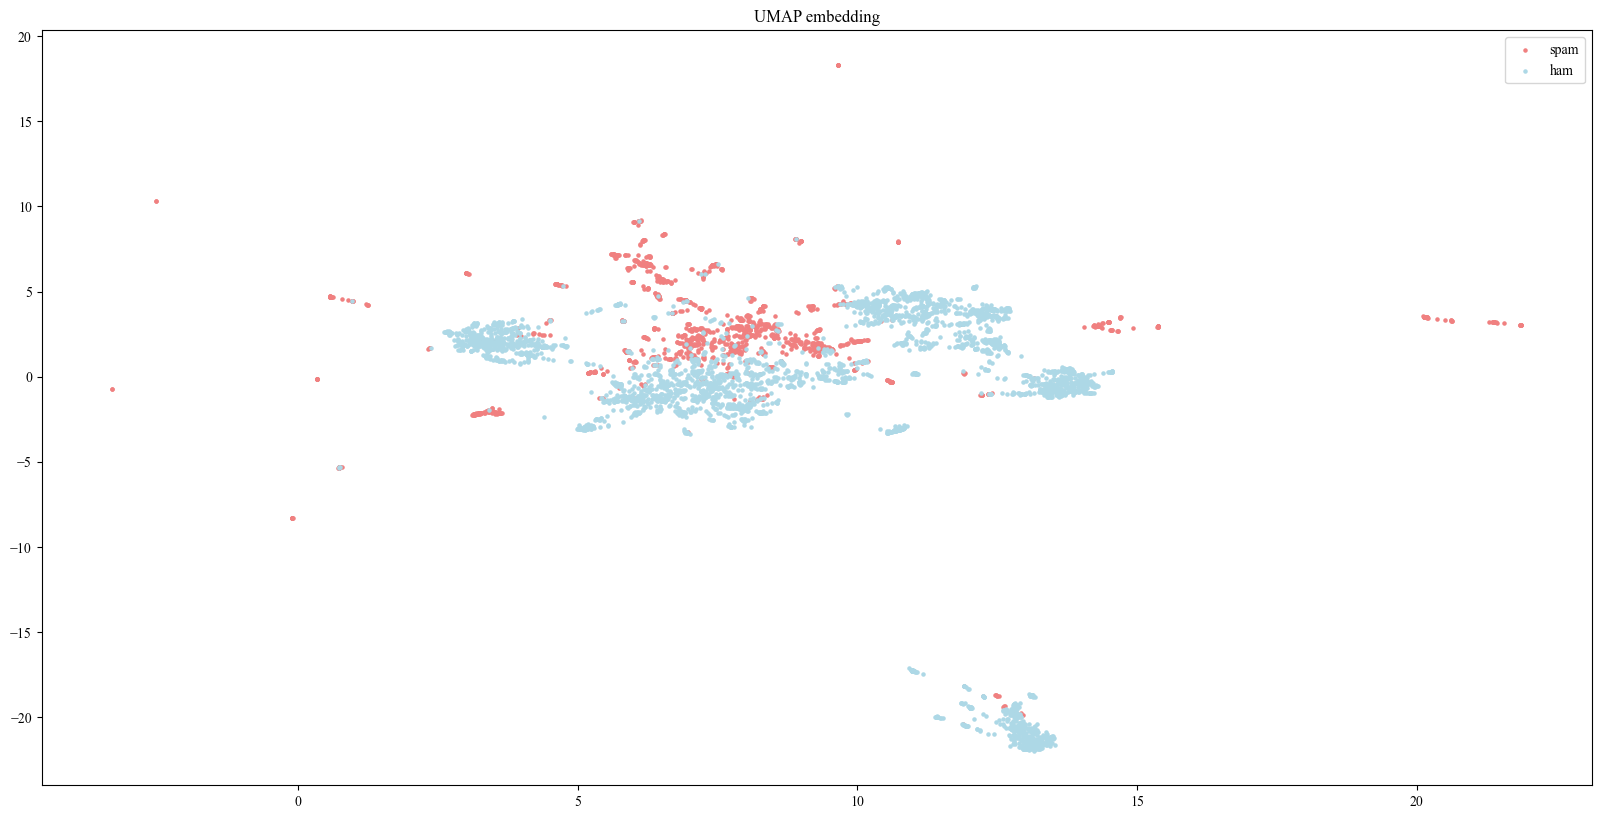

In [18]:

spam_idx = df['label']=='spam'
ham_idx = df['label']=='ham'

fig, ax = plt.subplots(1,figsize=(20,10), dpi=100)
ax.scatter(X_umap.T[0,:][spam_idx], X_umap.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax.scatter(X_umap.T[0,:][ham_idx], X_umap.T[1,:][ham_idx], c='lightblue',s=5, label='ham')
ax.set_title('UMAP embedding')
ax.legend()

plt.show()

## UMAP for downstream clustering

In [28]:
X_umap_dt = umap.UMAP(metric='cosine', n_components=30).fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 68 edges.
It has only fully disconnected 3 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [29]:
#UMAP unfortunately produces a few NaN values
NaN_idx = np.argwhere(np.isnan(X_umap_dt))
X_temp_dt = X_umap_dt[~np.isnan(X_umap_dt).any(axis=1)]

In [32]:
kmeans_assign, centroids = kmeans(X_temp_dt, k=2, random_state=2, tot=1e-4)

clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X_temp_dt)
dbscan_assign = clustering_db.labels_

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.459399137799946
Iteration number: 3 - diff 2.21959446275107
Current best inertia: 57609.27370549022
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.153194464581587
Iteration number: 3 - diff 2.620977079022197
Iteration number: 4 - diff 3.2354627649244723
Iteration number: 5 - diff 3.6811265298173517
Kmeans run no. 3
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.244987250451886
Iteration number: 3 - diff 1.5185021239121261
Iteration number: 4 - diff 0.9085709418476414
Iteration number: 5 - diff 0.22046388662704444
Iteration number: 6 - diff 0.0756967605899129
Iteration number: 7 - diff 0.05142969303816218
Iteration number: 8 - diff 0.003955809851285661
Iteration number: 9 - diff 0.0029857229359544065
Kmeans run no. 4
Number of centroids defined: 2
Iteration numbe

In [33]:
labels = df['label'].replace({'ham':0, 'spam':1}).values[~np.isnan(X_umap_dt).any(axis=1)]

performance_metrics(X_temp_dt, kmeans_assign, labels)
performance_metrics(X_temp_dt, dbscan_assign, labels)

ARI: -0.074
NMI: 0.067
DBI: 0.340


ARI: 0.042
NMI: 0.132
DBI: 1.507




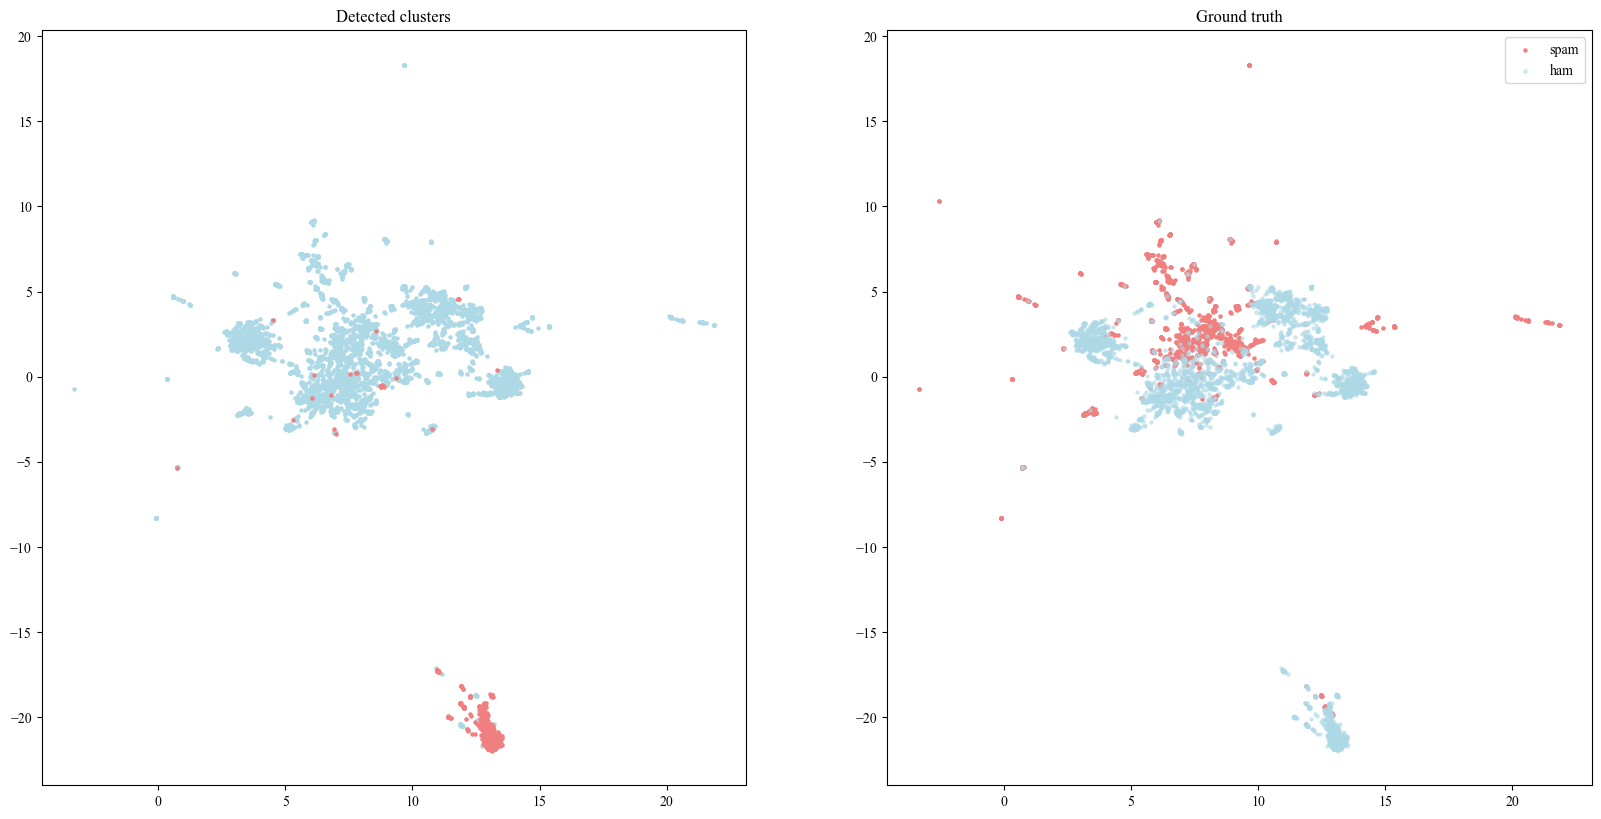

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10), dpi=100)

clust_1 = np.where(kmeans_assign==0)
clust_2 = np.where(kmeans_assign==1)

ax1.scatter(X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[0,:][clust_1], X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[1,:][clust_1], c='lightblue',s=5)
ax1.scatter(X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[0,:][clust_2], X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[1,:][clust_2], c='lightcoral',s=5)
ax1.set_title('Detected clusters')
#ax1.legend()

ax2.scatter(X_umap.T[0,:][spam_idx], X_umap.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax2.scatter(X_umap.T[0,:][ham_idx], X_umap.T[1,:][ham_idx], c='lightblue',s=5, label='ham', alpha=0.5)
ax2.set_title('Ground truth')
ax2.legend()

plt.show()

## Choosing suitable k
We will use the elbow method to determine the appropriate number of K.

In [41]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(X_temp_dt, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.459398799763449
Iteration number: 3 - diff 2.2195944827539003
Current best inertia: 57609.273245620796
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.153194403705603
Iteration number: 3 - diff 2.6209767278195506
Iteration number: 4 - diff 3.235463001641418
Iteration number: 5 - diff 3.681126584751907
Kmeans run no. 3
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.244987544974598
Iteration number: 3 - diff 1.518502054505205
Iteration number: 4 - diff 0.9085709061353637
Iteration number: 5 - diff 0.22046387538322226
Iteration number: 6 - diff 0.0756968404950703
Iteration number: 7 - diff 0.051429685791019544
Iteration number: 8 - diff 0.003955810779716502
Iteration number: 9 - diff 0.0029857011992918073
Kmeans run no. 4
Number of centroids defined: 2
Iteration num

Iteration number: 6 - diff 0.004369337356735078
Kmeans run no. 3
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 6.650023945007167
Iteration number: 3 - diff 0.45831638307560907
Iteration number: 4 - diff 0.2836480759458892
Iteration number: 5 - diff 0.5443374238376139
Iteration number: 6 - diff 1.0676851681457769
Iteration number: 7 - diff 0.7668149767959735
Iteration number: 8 - diff 0.5915154380838241
Iteration number: 9 - diff 0.3258135747499665
Iteration number: 10 - diff 0.1294240326239558
Iteration number: 11 - diff 0.057566633329530166
Iteration number: 12 - diff 0.002318007937433282
Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.210890510885209
Iteration number: 3 - diff 1.5254321683888952
Iteration number: 4 - diff 0.20024863049599448
Iteration

Iteration number: 4 - diff 0.4935230329499165
Iteration number: 5 - diff 0.7285201918375588
Iteration number: 6 - diff 1.476161888686245
Iteration number: 7 - diff 0.7746436156013669
Iteration number: 8 - diff 0.26602134530382093
Iteration number: 9 - diff 0.04912667395760778
Iteration number: 10 - diff 0.008499034430737754
Kmeans run no. 10
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.517395384524388
Iteration number: 3 - diff 2.026215014856904
Iteration number: 4 - diff 1.0791827179170448
Iteration number: 5 - diff 0.26966727808756663
Iteration number: 6 - diff 0.10108045716268099
Iteration number: 7 - diff 0.03706637296156989
Iteration number: 8 - diff 0.010950785505056612
Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6

Iteration number: 11 - diff 0.9232467671295679
Iteration number: 12 - diff 0.32437015044047807
Iteration number: 13 - diff 0.06965797535973656
Iteration number: 14 - diff 0.003258075267073988
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 6.430975509902758
Iteration number: 3 - diff 2.034066443447842
Iteration number: 4 - diff 1.6958465706147297
Iteration number: 5 - diff 0.9231002495451587
Iteration number: 6 - diff 0.053646756841527705
Kmeans run no. 6
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 9.017599301000624
Iteration number: 3 - diff 4.562402356896814
Iteration 

Iteration number: 4 - diff 0.14327233649917945
Iteration number: 5 - diff 0.04040329127466688
Iteration number: 6 - diff 1.2540159132635391
Iteration number: 7 - diff 0.04143590779000792
Kmeans run no. 9
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 6.670431153086175
Iteration number: 3 - diff 2.4965103832086806
Iteration number: 4 - diff 0.7327582207026345
Iteration number: 5 - diff 1.6853547332153558
Iteration number: 6 - diff 0.80321881533424
Iteration number: 7 - diff 0.27185622937266635
Iteration number: 8 - diff 0.03987193846243402
Iteration number: 9 - diff 0.005602363743785392
Kmeans run no. 10
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
N

Iteration number: 5 - diff 1.6807474944203475
Iteration number: 6 - diff 0.7991234406403357
Iteration number: 7 - diff 0.2727271111702064
Iteration number: 8 - diff 0.046374617051731036
Iteration number: 9 - diff 0.005348557254124188
Iteration number: 10 - diff 0.003831916490949151
Kmeans run no. 10
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.915935887634312
Iteration number: 3 - diff 0.4148786013503432
Iteration number: 4 - diff 0.29712120986840895
Iteration number: 5 - diff 0.09234159709257608
Iteration number: 6 - diff 0.025335637867884987
Iteration number: 7 - diff 0.006087869091474703


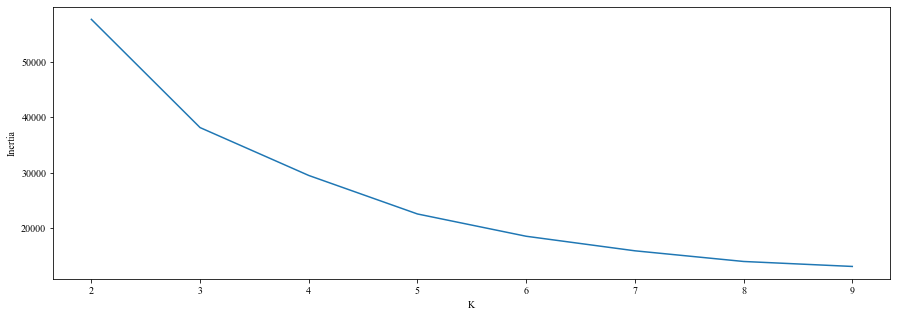

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

In [47]:
kmeans_assign, centroids, _ = kmeans(X_temp_dt, k=5, random_state=2, tot=1e-4)

performance_metrics(X_temp_dt, kmeans_assign, labels)

Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.669199742197332
Iteration number: 3 - diff 0.588776582171274
Iteration number: 4 - diff 0.24042834445653496
Iteration number: 5 - diff 0.10018786173513612
Iteration number: 6 - diff 0.030643348764254365
Current best inertia: 27815.015192211697
Kmeans run no. 2
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.5971261366692175
Iteration number: 3 - diff 2.4336312852149207
Iteration number: 4 - diff 1.4810478776132106
Iteration number: 5 - diff 1.4262187290183177
Iteration number: 6 - diff 0.8281977138985734
Iteration number: 7 - diff 0.42446739126794264
Iteration number: 8 - diff 0.08644508947789414
Iteration number: 9 - diff 0.03303041401762259
It

## What about SVD for dim reduction?

In [53]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=)
X_svd = svd.fit_transform(X)
var_explained = svd.explained_variance_ratio_.sum()
print(var_explained)

0.5219087504440939


In [54]:
X_svd.shape

(5512, 500)

In [55]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(X_svd, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.2944561444240006
Iteration number: 3 - diff 0.045796933558984
Iteration number: 4 - diff 0.016707000517067395
Iteration number: 5 - diff 0.015903017821317887
Iteration number: 6 - diff 0.0057940913009069395
Iteration number: 7 - diff 0.004858933893159432
Iteration number: 8 - diff 0.01051904287706826
Iteration number: 9 - diff 0.008302515325857152
Iteration number: 10 - diff 0.0027656305458215397
Iteration number: 11 - diff 0.0026652839239849004
Current best inertia: 2701.357869735883
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.0822175540867913
Iteration number: 3 - diff 0.24667968138606794
Iteration number: 4 - diff 0.17224165070425007
Iteration number: 5 - diff 0.09082384189685207
Iteration number: 6 - diff 0.04789561943435127
Iteration number: 7 - diff 0.04284547877658071
Iteration number: 8 - diff 0.049

Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.5959402407807604
Iteration number: 3 - diff 0.13238158285940668
Iteration number: 4 - diff 0.07423432097421807
Iteration number: 5 - diff 0.05373755597904368
Iteration number: 6 - diff 0.03735773925183378
Iteration number: 7 - diff 0.030946763474163738
Iteration number: 8 - diff 0.013423838320622477
Iteration number: 9 - diff 0.01295167070848578
Iteration number: 10 - diff 0.012440350503590778
Iteration number: 11 - diff 0.010038433497238602
Current best inertia: 2671.636372115467
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.4272162437825544
Iteration number: 3 - diff 0.0787235109414384
Iteration number: 4 - diff 0.07677071680042126
Iteration number: 5 - diff 0.12606579809949986
Iteration number: 6 - diff 0.08102302970019004
Iteration number: 7 - diff 0.06760654321855886
Iteration number: 8 - diff 0.039699549930498186
Iterat

Iteration number: 7 - diff 0.3185955992320158
Iteration number: 8 - diff 0.08497156270487137
Iteration number: 9 - diff 0.037094502131265875
Iteration number: 10 - diff 0.028079672896611868
Iteration number: 11 - diff 0.03370081813723697
Iteration number: 12 - diff 0.02992222827128086
Iteration number: 13 - diff 0.02676948094597603
Iteration number: 14 - diff 0.02440423591719076
Iteration number: 15 - diff 0.027891789516586954
Iteration number: 16 - diff 0.03399672902601741
Iteration number: 17 - diff 0.044100149987318066
Iteration number: 18 - diff 0.03239306486814052
Iteration number: 19 - diff 0.01961277114608182
Iteration number: 20 - diff 0.012736964063058272
Iteration number: 21 - diff 0.0061376680059502045
Iteration number: 22 - diff 0.001528361813601527
Kmeans run no. 6
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.8716630005405426
Iteration number: 3 - diff 0.3889024

Iteration number: 2 - diff 2.489521966448701
Iteration number: 3 - diff 0.27204840542605613
Iteration number: 4 - diff 0.22626653948308406
Iteration number: 5 - diff 0.3275809350759186
Iteration number: 6 - diff 0.49903782100011557
Iteration number: 7 - diff 0.3423661145324711
Iteration number: 8 - diff 0.09598998418559393
Iteration number: 9 - diff 0.041379858716473907
Iteration number: 10 - diff 0.035078062665811295
Iteration number: 11 - diff 0.030341501801783292
Iteration number: 12 - diff 0.027912281004264176
Iteration number: 13 - diff 0.029146862513969463
Iteration number: 14 - diff 0.02204926504920087
Iteration number: 15 - diff 0.02453309676871951
Iteration number: 16 - diff 0.024795123358247774
Iteration number: 17 - diff 0.030915594082115905
Iteration number: 18 - diff 0.04303750212307568
Iteration number: 19 - diff 0.03661061204162725
Iteration number: 20 - diff 0.02106433493055155
Iteration number: 21 - diff 0.01738110221693433
Iteration number: 22 - diff 0.009629483213515

Iteration number: 7 - diff 0.028007186491757638
Iteration number: 8 - diff 0.030489052469111287
Iteration number: 9 - diff 0.02785117497561394
Iteration number: 10 - diff 0.012303242172609443
Iteration number: 11 - diff 0.010502318448611608
Iteration number: 12 - diff 0.007782887285032591
Iteration number: 13 - diff 0.007058504184554128
Iteration number: 14 - diff 0.010109583275541751
Iteration number: 15 - diff 0.01740441028317795
Iteration number: 16 - diff 0.0221771891076899
Iteration number: 17 - diff 0.01783588767700943
Iteration number: 18 - diff 0.014452475937667245
Iteration number: 19 - diff 0.009242560423465608
Iteration number: 20 - diff 0.0029821339759366107
Iteration number: 21 - diff 0.001782319405453604
Iteration number: 22 - diff 0.0010297845733125963
Kmeans run no. 4
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration numb

Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.690250695470883
Iteration number: 3 - diff 0.7982647809864298
Iteration number: 4 - diff 0.3673254490559462
Iteration number: 5 - diff 0.3195456050291228
Iteration number: 6 - diff 0.29966525439659597
Iteration number: 7 - diff 0.10688767589494276
Iteration number: 8 - diff 0.08812569258698777
Iteration number: 9 - diff 0.08698753382138354
Iteration number: 10 - diff 0.06258697443348434
Iteration number: 11 - diff 0.04021823694334664
Iteration number: 12 - diff 0.016733599215838967
Iteration number: 13 - diff 0.01625675014389549
Iteration number: 14 - diff 0.011050105009586041
Iteration number: 15 - diff 0.008828297398080113
Iteration number: 16 - diff 0.005509673313799769
Iteration number: 17 - diff 0.0036468810850318993
Iteration number: 18 - diff 0.004016117524767532
Iteration number: 19 - diff 0.000789260877992519
Current best inertia: 2582.7998917490004
Km

Iteration number: 18 - diff 0.08205096380144618
Iteration number: 19 - diff 0.11851197730824142
Iteration number: 20 - diff 0.0771642149234533
Iteration number: 21 - diff 0.030861769181449113
Iteration number: 22 - diff 0.00891440758102197
Iteration number: 23 - diff 0.006568137542266732
Iteration number: 24 - diff 0.008085815640481548
Iteration number: 25 - diff 0.002950008353054767
Iteration number: 26 - diff 0.0022116206058857527
Iteration number: 27 - diff 0.0027913271252799697
Iteration number: 28 - diff 0.00225612221074259
Iteration number: 29 - diff 0.001625782467975684
Iteration number: 30 - diff 0.001530484728150431
Kmeans run no. 8
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.228269955327031
Iteration number: 3 - diff 0.45214934550068697
Iteration number: 4 - diff 0.4582888

Iteration number: 15 - diff 0.09011971105433758
Iteration number: 16 - diff 0.09654038257600843
Iteration number: 17 - diff 0.10188932644975446
Iteration number: 18 - diff 0.10537652449749729
Iteration number: 19 - diff 0.0757973723390448
Iteration number: 20 - diff 0.05752184607306979
Iteration number: 21 - diff 0.04958519531354284
Iteration number: 22 - diff 0.04986904513357629
Iteration number: 23 - diff 0.04658884594769399
Iteration number: 24 - diff 0.04401359640096918
Iteration number: 25 - diff 0.043226655168464384
Iteration number: 26 - diff 0.029274219058837418
Iteration number: 27 - diff 0.02957875913523378
Iteration number: 28 - diff 0.02710347798817412
Iteration number: 29 - diff 0.024050645787439526
Iteration number: 30 - diff 0.009714938239258912
Iteration number: 31 - diff 0.002882388636435094
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number o

Iteration number: 4 - diff 0.7384634940168554
Iteration number: 5 - diff 0.49413994819584023
Iteration number: 6 - diff 0.40157396980540827
Iteration number: 7 - diff 0.2774768207952618
Iteration number: 8 - diff 0.24705757241891885
Iteration number: 9 - diff 0.1954033638174195
Iteration number: 10 - diff 0.10149040362736746
Iteration number: 11 - diff 0.08626198559605258
Iteration number: 12 - diff 0.04025044368710601
Iteration number: 13 - diff 0.030556450520086015
Iteration number: 14 - diff 0.023734501668198085
Iteration number: 15 - diff 0.006448180565980487
Iteration number: 16 - diff 0.002073555270759478
Iteration number: 17 - diff 0.004963131943379946
Iteration number: 18 - diff 0.004225570228882548
Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 

Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 4.027808707222914
Iteration number: 3 - diff 1.3329164689221151
Iteration number: 4 - diff 0.5092038357348296
Iteration number: 5 - diff 0.28566496439147854
Iteration number: 6 - diff 0.15824082193318215
Iteration number: 7 - diff 0.11345584536383699
Iteration number: 8 - diff 0.05815870782386735
Iteration number: 9 - diff 0.03215905243877814
Iteration number: 10 - diff 0.013958070692237912
Iteration number: 11 - diff 0.009442214359306192
Iteration number: 12 - diff 0.0024308614531398285
Iteration number: 13 - diff 0.001916313222772462
Kmeans run no. 7
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number

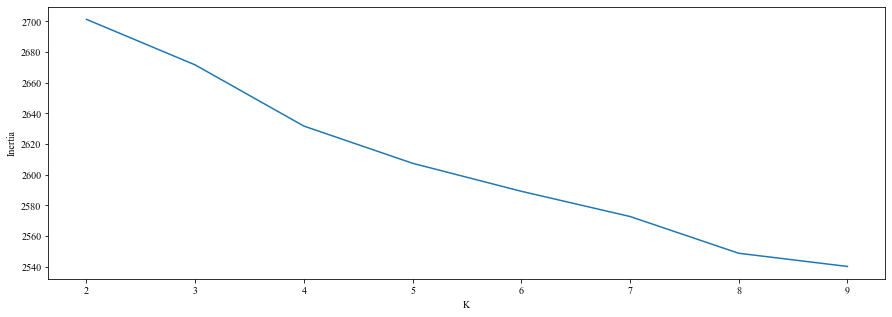

In [57]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

In [94]:
kmeans_assign, centroids, _ = kmeans(X_svd, k=4, random_state=2, tot=1e-4)

Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.1062971205559182
Iteration number: 3 - diff 0.2995584496166262
Iteration number: 4 - diff 0.11096852729017743
Iteration number: 5 - diff 0.06543935756459408
Iteration number: 6 - diff 0.08064331901815418
Iteration number: 7 - diff 0.0219158940599775
Iteration number: 8 - diff 0.029596192254808668
Iteration number: 9 - diff 0.029736121763031996
Iteration number: 10 - diff 0.02299174282466855
Iteration number: 11 - diff 0.012605294730773708
Iteration number: 12 - diff 0.023362591026030423
Iteration number: 13 - diff 0.005314156724158843
Iteration number: 14 - diff 0.0032614690478791324
Iteration number: 15 - diff 0.0005820288914984233
Iteration number: 16 - diff 0.0005920008898329739
Current best inertia: 2654.2584107955595
Kmeans run no. 2
Number of centroids defined: 2
Number of centroids defined: 3
Number of cent

Iteration number: 10 - diff 0.004233872664894766
Iteration number: 11 - diff 0.0025939832779438726
Iteration number: 12 - diff 0.0024631438106760173
Iteration number: 13 - diff 0.007917093558057635
Iteration number: 14 - diff 0.0036124439343636497


In [69]:
clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X_svd)
dbscan_assign = clustering_db.labels_

In [70]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(X_svd, kmeans_assign, labels)
performance_metrics(X_svd, dbscan_assign, labels)

ARI: 0.384
NMI: 0.338
DBI: 4.937


ARI: 0.359
NMI: 0.186
DBI: 0.824




# Spectral Decomposition

In [8]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(X)

In [9]:
# Define affinity matrix
A = similarity
#Seems to be an issue with sklearns cosine similarity
#some diag elements equal zero, which it shouldn't
#The following fixes the issue
np.fill_diagonal(A, 0.0)
row_sum = A.sum(0)
removed_idx = np.where(A.sum(0)==0)[0]
A_reduced = A[row_sum != 0, :]
A_reduced = A_reduced[:, row_sum!=0]

assert np.where(A_reduced.sum(0)==0)[0].size == 0
assert np.where(A_reduced.sum(1)==0)[0].size == 0

# Define D as a diagonal matrix where element (i,i) corresponds to the sum of ith row in A
D = np.diag(A_reduced.sum(axis=0))
D_pow = np.diag(np.power(np.diagonal(D), -0.5))
# Define L=D^{-1/2}AD^{-1/2}
L = D_pow@A_reduced@D_pow

In [10]:
# Find the k largest eigenvectors of L
eigenvals, eigenvectors = np.linalg.eigh(L)

In [71]:
k = 2
k_largest = np.argpartition(eigenvals, -k)[-k:]

In [72]:
#Create matrix X_spec = [x1,...,xk]
X_spec = eigenvectors[:, k_largest]

In [73]:
# Define Y as X row normalized
Y = X_spec/np.linalg.norm(X_spec, axis=0)

In [74]:
row_sums = np.power(X_spec, 2).sum(axis=1)
#row_sums = X_spec.sum(axis=1)
Y = (X_spec / np.power(row_sums[:, np.newaxis], 0.5))
#Y = X_spec / row_sums[:, np.newaxis]
Y = np.nan_to_num(Y)

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(Y, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias, c='darkblue')
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

In [75]:
kmeans_spec_assign, centroids, _ = kmeans(Y, k=3, random_state=2, tot=1e-4)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.5614827815198409
Iteration number: 3 - diff 0.03160761968652769
Iteration number: 4 - diff 0.01620250063569494
Iteration number: 5 - diff 0.010797875090794388
Iteration number: 6 - diff 0.00393261607398897
Iteration number: 7 - diff 0.002241811326435103
Iteration number: 8 - diff 0.001119036558438922
Current best inertia: 375.6816673955688
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.4661905238227713
Iteration number: 3 - diff 0.14155178491120407
Iteration number: 4 - diff 0.09361974636608009
Iteration number: 5 - diff 0.05117017413471655
Iteration number: 6 - diff 0.03160761968652769
Iteration number: 7 - diff 0.01620250063569494
Iteration number: 8 - diff 0.010797875090794388
Iteration number: 9 - diff 0.00393261607398897
Iteration number: 10 - diff 0.002241811326435103
Iteration number: 11 - diff 0.001119

In [76]:
labels = df.drop(removed_idx).label.replace({'ham':0, 'spam':1}).values
performance_metrics(Y, kmeans_spec_assign, labels)

ARI: 0.535
NMI: 0.399
DBI: 0.557




These are actually the best results obtained yet. Let us use these result for the post analysis of algorithmic behaviour.

# Cosine Distance

In [71]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.cluster import DBSCAN, KMeans
dist = pairwise_distances(X, metric='cosine')


In [72]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(dist, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 3.818988752631329
Iteration number: 3 - diff 0.5424460617193505
Iteration number: 4 - diff 0.5186835068846276
Iteration number: 5 - diff 0.7750304360852133
Iteration number: 6 - diff 0.8772311303306418
Iteration number: 7 - diff 0.900531472835929
Iteration number: 8 - diff 1.3085013775238636
Iteration number: 9 - diff 1.0958669309855447
Iteration number: 10 - diff 0.8168739865219776
Iteration number: 11 - diff 0.3206538742993799
Iteration number: 12 - diff 0.19537510391330848
Iteration number: 13 - diff 0.014418890149013276
Current best inertia: 38722.45943056801
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 4.767977860988513
Iteration number: 3 - diff 2.2496729608208033
Iteration number: 4 - diff 1.52903444472786
Iteration number: 5 - diff 1.0797250809542647
Iteration number: 6 - diff 0.8088744152408325
Iteratio

Iteration number: 27 - diff 0.029411096200482136
Iteration number: 28 - diff 0.026809142757713785
Iteration number: 29 - diff 0.012657181034410544
Iteration number: 30 - diff 0.009913366458712719
Iteration number: 31 - diff 0.006126245440093369
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.707335258646417
Iteration number: 3 - diff 0.7184612081581185
Iteration number: 4 - diff 0.23159319574543472
Iteration number: 5 - diff 0.07142323788983468
Iteration number: 6 - diff 0.054092275163023576
Iteration number: 7 - diff 0.03035018414235521
Iteration number: 8 - diff 0.027097794502711135
Iteration number: 9 - diff 0.024594974587142153
Iteration number: 10 - diff 0.021060889939589773
Iteration number: 11 - diff 0.012827425026958685
Iteration number: 12 - diff 0.009541844873433136
Iteration number: 13 - diff 0.006410760920984985
Iteration number: 14 - diff 0.005868651639763222
Iteration number: 1

Iteration number: 6 - diff 0.5528374145222993
Iteration number: 7 - diff 0.3221531306337543
Iteration number: 8 - diff 0.18053830593922277
Iteration number: 9 - diff 0.12490840063327721
Iteration number: 10 - diff 0.06381041167759749
Iteration number: 11 - diff 0.04095717780197329
Iteration number: 12 - diff 0.03829338652806931
Iteration number: 13 - diff 0.024795892712014246
Iteration number: 14 - diff 0.023886901004080995
Iteration number: 15 - diff 0.03975439098027356
Iteration number: 16 - diff 0.01497913116943112
Iteration number: 17 - diff 0.01647417507400676
Iteration number: 18 - diff 0.021567064205511306
Iteration number: 19 - diff 0.021912357927583677
Iteration number: 20 - diff 0.021753841584965516
Iteration number: 21 - diff 0.020474229433725226
Iteration number: 22 - diff 0.02330851813841745
Iteration number: 23 - diff 0.042379336774066835
Iteration number: 24 - diff 0.07435283275016315
Iteration number: 25 - diff 0.0962075895859178
Iteration number: 26 - diff 0.0643898814

Iteration number: 16 - diff 0.006210172770654409
Iteration number: 17 - diff 0.00938163086043927
Iteration number: 18 - diff 0.0076498446379426165
Iteration number: 19 - diff 0.006099730475390755
Iteration number: 20 - diff 0.004090506295498473
Iteration number: 21 - diff 0.004860842624882826
Iteration number: 22 - diff 0.0018698038289407786
Iteration number: 23 - diff 0.002018903705053213
Iteration number: 24 - diff 0.0051371980028018255
Iteration number: 25 - diff 0.004368092931683455
Iteration number: 26 - diff 0.003994212539672521
Iteration number: 27 - diff 0.0021787620605674993
Kmeans run no. 10
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.622564863156324
Iteration number: 3 - diff 1.6667139041929766
Iteration number: 4 - diff 1.192690224289343
Iteration number: 5 - diff 1.4939011571874956
Iteration number: 6 - diff 1.4821576035124076
Iteration number: 7 - diff 1.24197

Iteration number: 10 - diff 0.10218407437246861
Iteration number: 11 - diff 0.07550972442418895
Iteration number: 12 - diff 0.10081670180164953
Iteration number: 13 - diff 0.06391249504031918
Iteration number: 14 - diff 0.04571191403684567
Iteration number: 15 - diff 0.03625698838201816
Iteration number: 16 - diff 0.03078918220909361
Iteration number: 17 - diff 0.03176499558865569
Iteration number: 18 - diff 0.010864342348877854
Iteration number: 19 - diff 0.0042783701078937825
Iteration number: 20 - diff 0.0036890648683065505
Current best inertia: 31625.99095812314
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 11.385048655693407
Iteration number: 3 - diff 1.7120817991200439
Iteration number: 4 - diff 0.5900691318570197
Iteration number: 5 - diff 0.6628146803242163
Iteration number: 6 - diff 0.3231268066697093
Iteration number: 7 

Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 11.231723016161817
Iteration number: 3 - diff 5.612836604573853
Iteration number: 4 - diff 2.5844390673889057
Iteration number: 5 - diff 1.4797420448695924
Iteration number: 6 - diff 0.5499038428248275
Iteration number: 7 - diff 0.3380459834495757
Iteration number: 8 - diff 0.18543903755500693
Iteration number: 9 - diff 0.35132763519884236
Iteration number: 10 - diff 0.55916297578875
Iteration number: 11 - diff 0.588300061623414
Iteration number: 12 - diff 0.6278119734211501
Iteration number: 13 - diff 0.8601950967598386
Iteration number: 14 - diff 0.5844052358468967
Iteration number: 15 - diff 0.4272621822984087
Iteration number: 16 - diff 0.24202864460568407
Iteration number: 17 - diff 0.06835764084526144
Iteration number: 18 - diff 0.0465470724013912
Iteration number: 19 - diff 0.020685213694696055


Kmeans run no. 9
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 14.347217934984922
Iteration number: 3 - diff 2.3934989027568223
Iteration number: 4 - diff 1.323490174744567
Iteration number: 5 - diff 0.8778616569066799
Iteration number: 6 - diff 0.7442908075010182
Iteration number: 7 - diff 0.3398109861988867
Iteration number: 8 - diff 0.5753115055599259
Iteration number: 9 - diff 0.24837684408307795
Iteration number: 10 - diff 0.17141484287773348
Iteration number: 11 - diff 0.1510768475886366
Iteration number: 12 - diff 0.05476941715369544
Iteration number: 13 - diff 0.05300676503784804
Iteration number: 14 - diff 0.0776511603280222
Iteration number: 15 - diff 0.07786615056424236
Iteration number: 16 - diff 0.049664929491096
Iteration number: 17 - diff 0.04462188850985916
Iteration number: 18 - diff 0.02393041422602

Iteration number: 16 - diff 0.06486084224504786
Iteration number: 17 - diff 0.1001050377346741
Iteration number: 18 - diff 0.06882542412910213
Iteration number: 19 - diff 0.028167607266510346
Iteration number: 20 - diff 0.010915909815550393
Iteration number: 21 - diff 0.01109427982666305
Iteration number: 22 - diff 0.0029758854626589404
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 14.795398878428937
Iteration number: 3 - diff 3.173192138870979
Iteration number: 4 - diff 1.370166364889879
Iteration number: 5 - diff 1.1754759154722543
Iteration number: 6 - diff 0.9109125485310998
Iteration number: 7 - diff 1.2115177359408131
Iteration number: 8 - diff 0.8844093670688815
Iteration number: 9 - diff 0.9885114790368221
Iteration number: 10 - diff 0.5671759192803798
Iteration

Iteration number: 25 - diff 0.008375210644633396
Iteration number: 26 - diff 0.01667921784329981
Iteration number: 27 - diff 0.004510031664680399
Iteration number: 28 - diff 0.01668886976457786
Iteration number: 29 - diff 0.011456934689553501
Iteration number: 30 - diff 0.004547522876537837
Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 14.755968012432293
Iteration number: 3 - diff 3.0624770465828934
Iteration number: 4 - diff 1.8350348840726367
Iteration number: 5 - diff 0.9926463742845708
Iteration number: 6 - diff 0.9769220444815956
Iteration number: 7 - diff 0.581898796683839
Iteration number: 8 - diff 0.5638630365161261
Iteration number: 9 - diff 1.2018536605164125
Iteration number: 10 - diff 0.9350430371483701
Iteration number: 11 - d

Iteration number: 16 - diff 0.0867877141974125
Iteration number: 17 - diff 0.10364175652878253
Iteration number: 18 - diff 0.02819644894169374
Iteration number: 19 - diff 0.013414745132988667
Kmeans run no. 5
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 16.15754147376392
Iteration number: 3 - diff 3.407702306826313
Iteration number: 4 - diff 2.7855512952614263
Iteration number: 5 - diff 1.3843933367640116
Iteration number: 6 - diff 0.7594445047135285
Iteration number: 7 - diff 0.8978996989805582
Iteration number: 8 - diff 0.8955155837384663
Iteration number: 9 - diff 0.5287383917014945
Iteration number: 10 - diff 0.3252152411767734
Iteration number: 11 - diff 0.13638794481797623
Iteration number: 12 - diff 0.05787223094697494
Iteration number: 13 - diff 0

Iteration number: 27 - diff 0.7714840588379586
Iteration number: 28 - diff 0.3071264751200048
Iteration number: 29 - diff 0.14567272334248382
Iteration number: 30 - diff 0.10100407998894875
Iteration number: 31 - diff 0.07333694334540666
Iteration number: 32 - diff 0.0911962848469101
Iteration number: 33 - diff 0.04909483779118978
Iteration number: 34 - diff 0.03978041160281359
Iteration number: 35 - diff 0.03933067275647626
Iteration number: 36 - diff 0.05277273850614929
Iteration number: 37 - diff 0.030750775635481627
Kmeans run no. 10
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Number of centroids defined: 5
Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 15.52031939888905
Iteration number: 3 - diff 3.175743309099161
Iteration number: 4 - diff 1.6546065280873599
Iteration number: 5 - diff 1.4085119192402455
Iteration number: 6 -

Number of centroids defined: 6
Number of centroids defined: 7
Number of centroids defined: 8
Number of centroids defined: 9
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 15.98874028500697
Iteration number: 3 - diff 3.554671170005096
Iteration number: 4 - diff 2.33019680466251
Iteration number: 5 - diff 1.6677759860253216
Iteration number: 6 - diff 0.9873664604537682
Iteration number: 7 - diff 0.5568034559564864
Iteration number: 8 - diff 0.6887639373998307
Iteration number: 9 - diff 0.9460672352145053
Iteration number: 10 - diff 1.2527099648729008
Iteration number: 11 - diff 1.2728792518040175
Iteration number: 12 - diff 0.8629815525942173
Iteration number: 13 - diff 0.7214980881650667
Iteration number: 14 - diff 0.8636599612630682
Iteration number: 15 - diff 0.48588026821535096
Iteration number: 16 - diff 0.3318646809797442
Iteration number: 17 - diff 0.16189094558801664
Iteration number: 18 - diff 0.04701599472249104
Iteration number: 19 - diff 0.04717346714008506
It

Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 19.01334436890178
Iteration number: 3 - diff 3.8185310737352722
Iteration number: 4 - diff 2.0826575224501434
Iteration number: 5 - diff 0.6829253503342091
Iteration number: 6 - diff 0.5708181205104708
Iteration number: 7 - diff 0.5914713333561046
Iteration number: 8 - diff 0.2632879600836824
Iteration number: 9 - diff 0.1766898876847524
Iteration number: 10 - diff 0.08684426612272221
Iteration number: 11 - diff 0.02586366276626444
Iteration number: 12 - diff 0.01087690420782811
Iteration number: 13 - diff 0.009263190072046025
Iteration number: 14 - diff 0.005221020223878975
Iteration number: 15 - diff 0.004398985430424623
Iteration number: 16 - diff 0.003812512300670594
Iteration number: 17 - diff 0.2638594844379645
Iteration number: 18 - diff 0.24807507513133475
Iteration number: 19 - diff 0.05077546377794961
Iteration number: 20 - diff 0.07295452067411584
Iteration number: 21 - diff 0.0179700694006912
Kmeans run no. 10
N

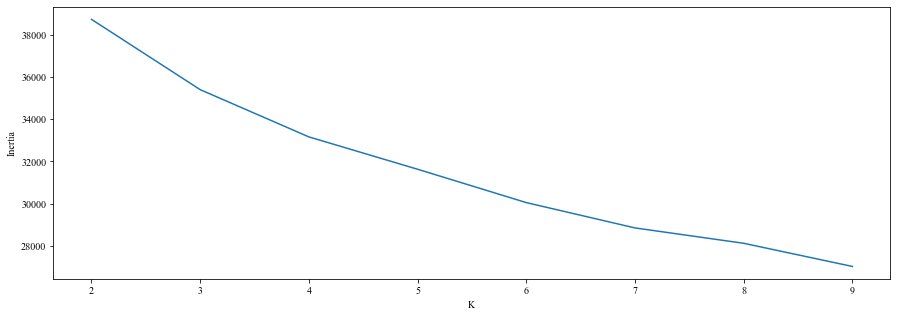

In [74]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

In [102]:
kmeans_assign, centroids_kmeans, _ = kmeans(dist, k=4, random_state=2, tot=0.0001, n_init=10)

Kmeans run no. 1
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.615626217699825
Iteration number: 3 - diff 0.8142865854787832
Iteration number: 4 - diff 0.7251746375158589
Iteration number: 5 - diff 0.8914699627061569
Iteration number: 6 - diff 0.5832578188112156
Iteration number: 7 - diff 0.26550844761289155
Iteration number: 8 - diff 0.2928737565995988
Iteration number: 9 - diff 0.12189424620511632
Iteration number: 10 - diff 0.0969218600509539
Iteration number: 11 - diff 0.07648362069902485
Iteration number: 12 - diff 0.02718758032365044
Current best inertia: 33157.04015881187
Kmeans run no. 2
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 7.638558999470332
Iteration number: 3 - diff 4.117368492900035
Iteration number: 4 - diff 1.7585024510797866
Iteration number: 5 

Iteration number: 21 - diff 0.015315601392140853
Iteration number: 22 - diff 0.011031809418984287
Iteration number: 23 - diff 0.015463359524747
Iteration number: 24 - diff 0.016256702127455183
Iteration number: 25 - diff 0.011768462604987593
Iteration number: 26 - diff 0.006054415097468273
Kmeans run no. 8
Number of centroids defined: 2
Number of centroids defined: 3
Number of centroids defined: 4
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 8.941771748068879
Iteration number: 3 - diff 1.7860696421644622
Iteration number: 4 - diff 1.2961778304205511
Iteration number: 5 - diff 1.2392403073131661
Iteration number: 6 - diff 0.9494840205600346
Iteration number: 7 - diff 0.5718760293113314
Iteration number: 8 - diff 0.32382958560036346
Iteration number: 9 - diff 0.2320947037845583
Iteration number: 10 - diff 0.10979803353245922
Iteration number: 11 - diff 0.0335169891630278
Iteration number: 12 - diff 0.014916440845276586
Iteration number: 13 - diff 0.010298400390429294
It

In [103]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(dist, kmeans_assign, labels)

ARI: 0.241
NMI: 0.274
DBI: 2.352




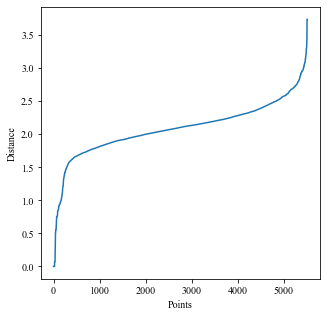

In [89]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=100)
neighbors = nearest_neighbors.fit(dist)
distances, indices = neighbors.kneighbors(dist)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
#plt.xlim([0, 500])
plt.savefig("Distance_curve.png", dpi=300)

In [104]:
dist = pairwise_distances(X, metric='cosine')
clustering_db = DBSCAN(eps=0.1, min_samples=2, metric='precomputed').fit(dist)
dbscan_assign = clustering_db.labels_

In [105]:
performance_metrics(dist, dbscan_assign, labels)

ARI: 0.348
NMI: 0.181
DBI: 0.921


